In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
sim = InteractiveContext(path, setup=False)

In [3]:
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                               'age_start': 40,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-11-20 13:56:37.841 | INFO     | simulation_1-artifact_manager:67 - Running simulation from artifact located at /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/artifacts/51-locations/v3-20231019/alabama.hdf.
2023-11-20 13:56:37.844 | INFO     | simulation_1-artifact_manager:68 - Artifact base filter terms are ['draw == 0'].
2023-11-20 13:56:37.847 | INFO     | simulation_1-artifact_manager:69 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,entrance_time,age,sex,alive,location,exit_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_multiplier,sbp_therapeutic_inertia_constant_component,ldlc_medication,lifestyle,ldlc_therapeutic_inertia_constant_component,sbp_medication_start_date,sbp_medication,scheduled_date,visit_type,last_fpg_test_date
0,True,2020-12-04,62.325405,Female,alive,Alabama,NaT,not_dead,0.0,,...,1.3620,-0.050506,medium_intensity,NaT,0.095895,NaT,no_treatment,NaT,none,NaT
1,True,2020-12-04,56.583394,Male,alive,Alabama,NaT,not_dead,0.0,,...,1.5125,0.901321,high_intensity,NaT,0.528809,NaT,no_treatment,2021-03-21 23:06:47.554560,none,NaT
2,True,2020-12-04,63.072592,Female,alive,Alabama,NaT,not_dead,0.0,,...,1.0000,-0.448101,no_treatment,NaT,0.558211,NaT,no_treatment,NaT,none,NaT
3,True,2020-12-04,50.472918,Male,alive,Alabama,NaT,not_dead,0.0,,...,1.0000,0.133548,low_intensity,NaT,-0.027969,2018-12-13 07:37:42.420016712,two_drug_half_dose_efficacy,NaT,none,NaT
4,True,2020-12-04,49.552787,Female,alive,Alabama,NaT,not_dead,0.0,,...,1.3620,-0.216679,medium_intensity,NaT,-0.353543,2019-07-26 10:50:23.423495504,one_drug_half_dose_efficacy,NaT,none,NaT


In [5]:
#pop0.columns

In [6]:
#sim.list_values()

In [5]:
data1 = pd.concat([pop0,
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl_raw'),
                   sim.get_value('high_ldl_cholesterol.raw_exposure')(pop0.index).rename('high_ldl_raw'),
                  ], axis=1)
data1.head()

,tracked,entrance_time,age,sex,alive,location,exit_time,cause_of_death,years_of_life_lost,previous_ischemic_stroke,...,ldlc_therapeutic_inertia_constant_component,sbp_medication_start_date,sbp_medication,scheduled_date,visit_type,last_fpg_test_date,high_sbp,high_sbp_raw,high_ldl_raw,high_ldl_raw
0,True,2020-12-04,62.325405,Female,alive,Alabama,NaT,not_dead,0.0,,...,0.095895,NaT,no_treatment,NaT,none,NaT,147.192049,147.192049,1.847632,2.764740
1,True,2020-12-04,56.583394,Male,alive,Alabama,NaT,not_dead,0.0,,...,0.528809,NaT,no_treatment,2021-03-21 23:06:47.554560,none,NaT,145.689753,145.689753,1.772176,3.577310
2,True,2020-12-04,63.072592,Female,alive,Alabama,NaT,not_dead,0.0,,...,0.558211,NaT,no_treatment,NaT,none,NaT,94.942811,94.942811,2.687280,2.687280
3,True,2020-12-04,50.472918,Male,alive,Alabama,NaT,not_dead,0.0,,...,-0.027969,2018-12-13 07:37:42.420016712,two_drug_half_dose_efficacy,NaT,none,NaT,148.753688,165.153688,2.202357,2.202357
4,True,2020-12-04,49.552787,Female,alive,Alabama,NaT,not_dead,0.0,,...,-0.353543,2019-07-26 10:50:23.423495504,one_drug_half_dose_efficacy,NaT,none,NaT,139.227528,139.227528,1.872148,2.801425


In [6]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
#data1.loc[data1.sbp_medication != 'no_treatment']

## Running time forward 

In [ ]:
reset_sbp_medication(2)

In [ ]:
## I would reset this to 1 time step or 5 time steps to test it 

sim_data = pd.DataFrame()
for step in list(range(0,12*20)):
    sim.step()
    pop_t = sim.get_population()
    #reset_sbp_medication(step) 
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_systolic_blood_pressure.raw_exposure')(pop0.index).rename('high_sbp_raw'),
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_ldl_cholesterol.raw_exposure')(pop0.index).rename('high_ldl_raw'),
                       ],axis=1)
    data_t['step'] = step
    data_t_small = data_t[['sex','age','alive','high_sbp','high_sbp_raw','high_ldl','high_ldl_raw','sbp_medication','ldlc_medication','step']]
    print(step)
    sim_data = pd.concat([sim_data, data_t_small])

0
1
2
3
4
5
6
7
8
9
10
11
12


In [ ]:
## Save the data - I find this helpful so that if things happen overnight (internet outage, jupyter crash) I still have a copy 

sim_data.to_csv('/ihme/homes/lutzes/med_data_240steps_11_20_23_v2.csv')

# Read in Data and Analysis 

In [4]:
data = pd.read_csv('/ihme/homes/lutzes/med_data_120steps_11_20_23.csv')

In [5]:
data1 = data.loc[(data.age > 25) & (data.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)
data1['sex_numeric'] = np.where(data1.sex == 'Male', 1, 0)
data1['ascvd'] = -19.5 + (0.043 * data1.high_sbp) + (0.266 * data1.age) + (2.32 * data1.sex_numeric)
data1['need_ldl_meds'] = np.where((data1.age > 70) & (data1.high_ldl_raw > 3.48), 1, 0)
data1['need_ldl_meds'] = np.where((data1.ascvd > 7.5) & (data1.high_ldl_raw > 1.81), 1, 0)
data1['need_sbp_meds'] = np.where(data1.high_sbp_raw > 130, 1, 0)

In [6]:
data_need_sbp_med = data1.loc[data1.need_sbp_meds == 1]
data_need_sbp_med.head()

,Unnamed: 0,sex,age,alive,high_sbp,high_sbp_raw,high_ldl,high_ldl_raw,sbp_medication,ldlc_medication,step,age_start,sex_numeric,ascvd,need_ldl_meds,need_sbp_meds
0,0,Female,62.402065,alive,147.192049,147.192049,1.847632,2.764740,no_treatment,medium_intensity,0,60.0,0,3.428207,0,1
1,1,Male,56.660054,alive,145.689753,145.689753,1.772176,3.577310,no_treatment,high_intensity,0,55.0,1,4.156234,0,1
3,3,Male,50.549578,alive,148.753688,165.153688,2.202357,2.202357,two_drug_half_dose_efficacy,low_intensity,0,50.0,1,2.662596,0,1
4,4,Female,49.629446,alive,139.227528,139.227528,1.872148,2.801425,one_drug_half_dose_efficacy,medium_intensity,0,45.0,0,-0.311784,0,1
5,5,Male,43.606462,alive,135.545603,135.545603,2.229095,2.229095,no_treatment,no_treatment,0,40.0,1,0.247780,0,1


In [7]:
data_need_ldl_med = data1.loc[data1.need_ldl_meds == 1]
data_need_ldl_med.head()

,Unnamed: 0,sex,age,alive,high_sbp,high_sbp_raw,high_ldl,high_ldl_raw,sbp_medication,ldlc_medication,step,age_start,sex_numeric,ascvd,need_ldl_meds,need_sbp_meds
9,9,Male,73.945806,alive,153.798856,174.098856,3.348176,3.348176,two_drug_std_dose_efficacy,no_treatment,0,70.0,1,9.102935,1,1
21,21,Male,71.277734,alive,146.336642,160.836642,3.336041,3.336041,two_drug_half_dose_efficacy,low_intensity,0,70.0,1,8.072353,1,1
24,24,Male,76.879217,alive,161.334637,169.634637,3.210388,3.210388,one_drug_half_dose_efficacy,low_intensity,0,75.0,1,10.207261,1,1
29,29,Female,85.418557,alive,111.127580,115.527580,1.985096,2.970438,one_drug_half_dose_efficacy,medium_intensity,0,85.0,0,7.999822,1,0
44,44,Male,88.381752,alive,157.148136,164.648136,2.290653,4.623905,one_drug_half_dose_efficacy,high_intensity,0,85.0,1,13.086916,1,1


In [8]:
grouped_ldl = data_need_ldl_med.groupby(['sex','age_start','step','ldlc_medication']).size()
errors_ldl = pd.DataFrame(grouped_ldl).reset_index()
errors_ldl['error'] = np.sqrt(errors_ldl[0])
#errors
percentages_ldl = grouped_ldl / data_need_ldl_med.groupby(['sex','age_start','step']).size() * 100
percentages_ldl= pd.DataFrame(percentages_ldl)
percentages_ldl = percentages_ldl.reset_index()
percentages_ldl = percentages_ldl.merge(errors_ldl[['sex','age_start','step','ldlc_medication','error']], on = ['sex','age_start','step','ldlc_medication'])
percentages_ldl['final_error'] = percentages_ldl[0].std() / percentages_ldl['error']
percentages_ldl.head()

,sex,age_start,step,ldlc_medication,0,error,final_error
0,Female,65.0,0,low_intensity,100.0,1.0,24.865817
1,Female,65.0,1,low_intensity,100.0,1.0,24.865817
2,Female,65.0,2,low_intensity,100.0,1.0,24.865817
3,Female,65.0,3,low_intensity,100.0,1.0,24.865817
4,Female,65.0,4,low_intensity,50.0,1.0,24.865817


In [9]:
grouped_sbp = data_need_sbp_med.groupby(['sex','age_start','step','sbp_medication']).size()
errors_sbp = pd.DataFrame(grouped_sbp).reset_index()
errors_sbp['error'] = np.sqrt(errors_sbp[0])
#errors
percentages_sbp = grouped_sbp / data_need_sbp_med.groupby(['sex','age_start','step']).size() * 100
percentages_sbp= pd.DataFrame(percentages_sbp)
percentages_sbp = percentages_sbp.reset_index()
percentages_sbp = percentages_sbp.merge(errors_sbp[['sex','age_start','step','sbp_medication','error']], on = ['sex','age_start','step','sbp_medication'])
percentages_sbp['final_error'] = percentages_sbp[0].std() / percentages_sbp['error']
percentages_sbp.head()

,sex,age_start,step,sbp_medication,0,error,final_error
0,Female,40.0,0,no_treatment,58.709677,9.539392,1.963680
1,Female,40.0,0,one_drug_half_dose_efficacy,25.161290,6.244998,2.999571
2,Female,40.0,0,one_drug_std_dose_efficacy,0.645161,1.000000,18.732317
3,Female,40.0,0,two_drug_half_dose_efficacy,15.483871,4.898979,3.823718
4,Female,40.0,1,no_treatment,56.493506,9.327379,2.008315


/tmp/ipykernel_4078198/1452645024.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


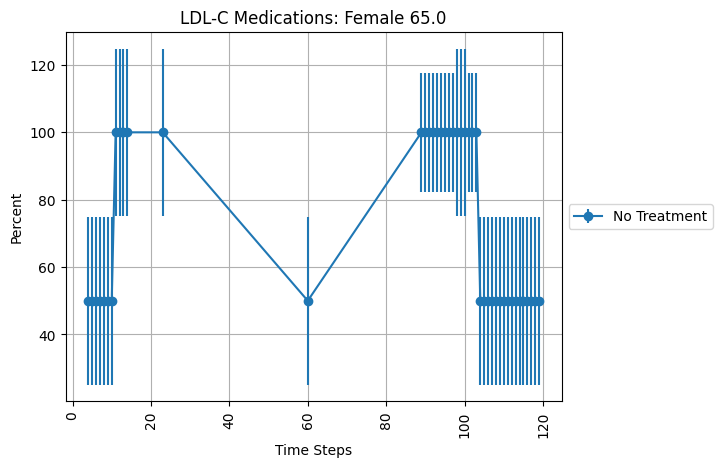

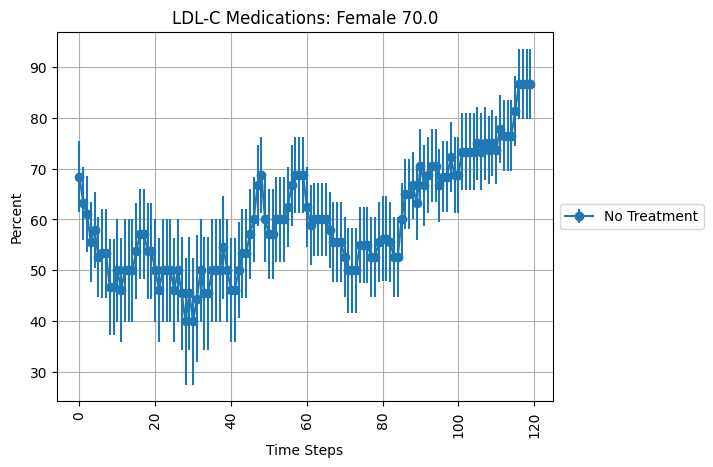

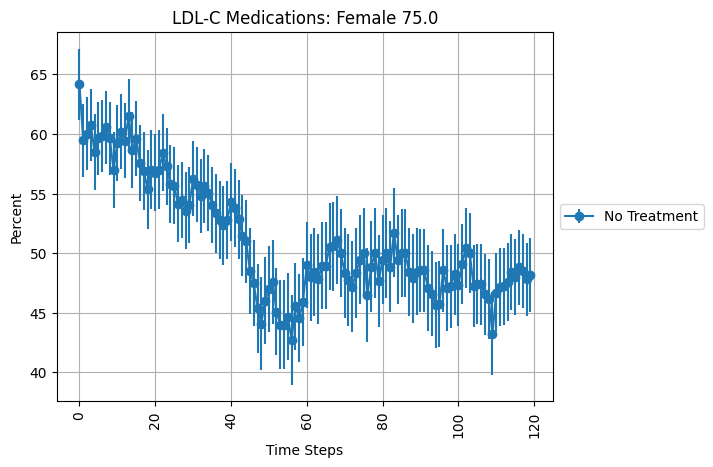

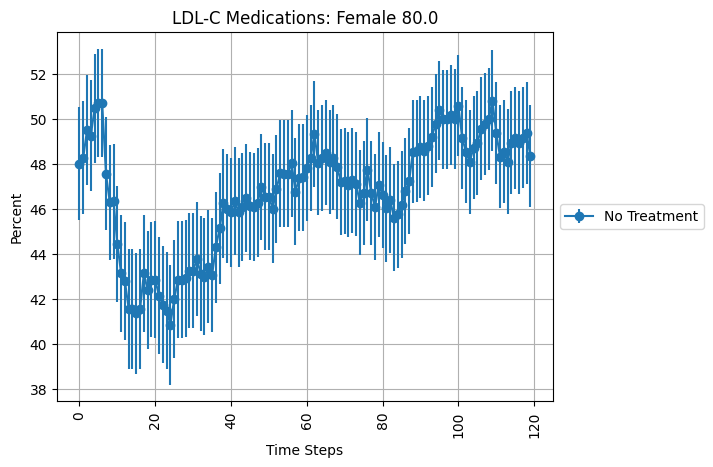

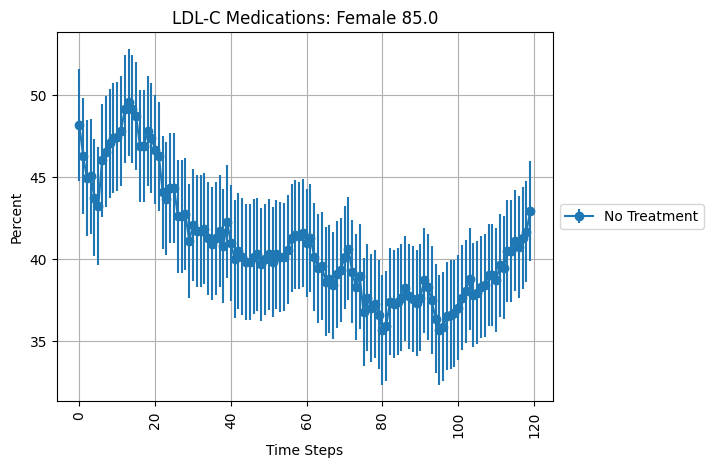

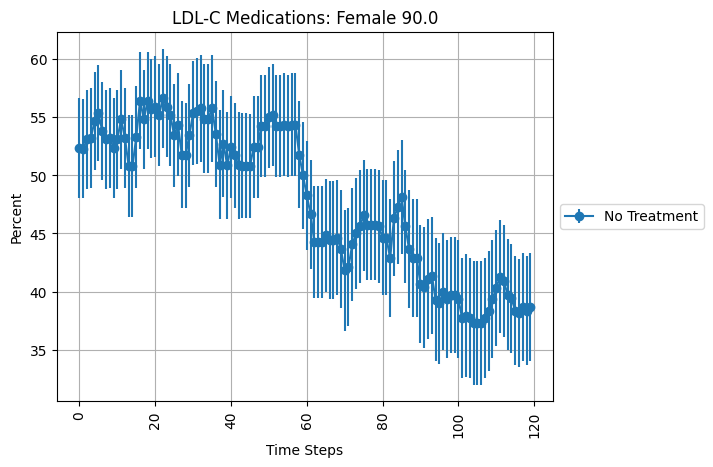

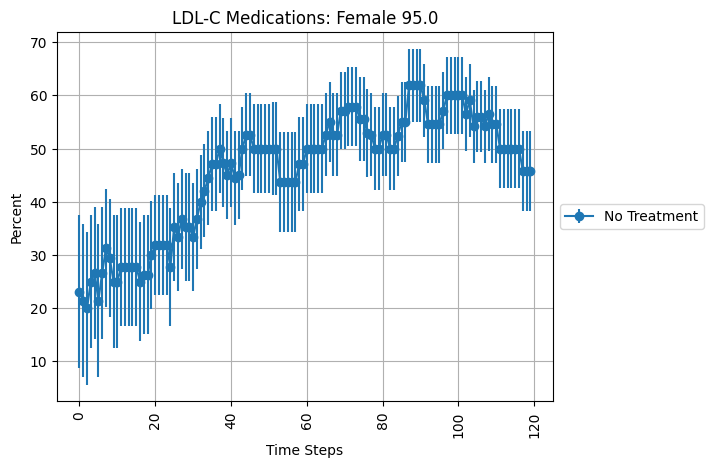

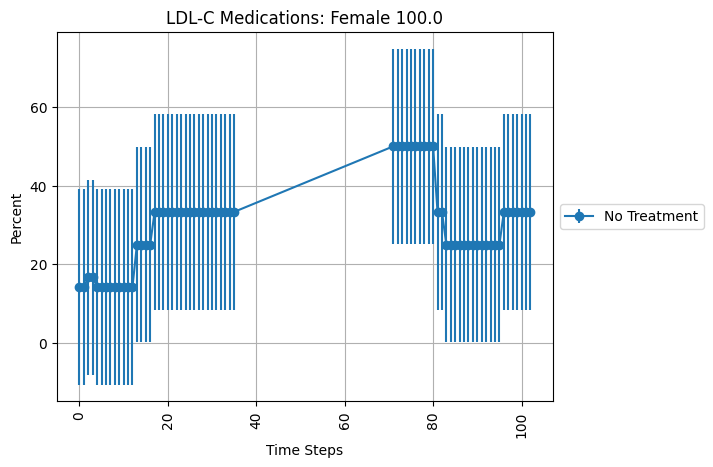

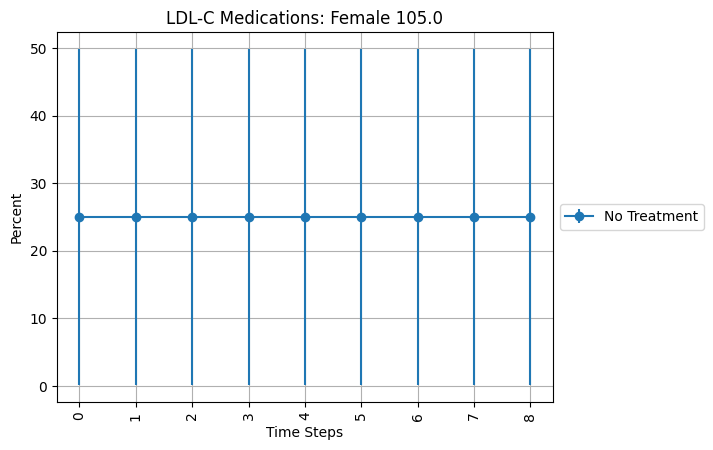

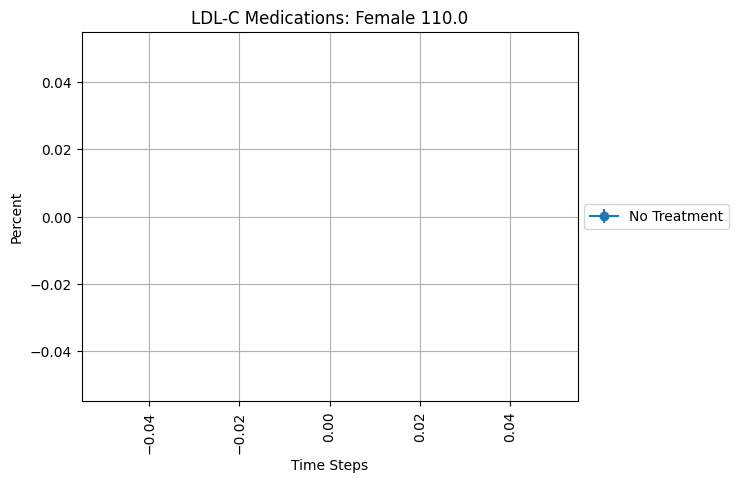

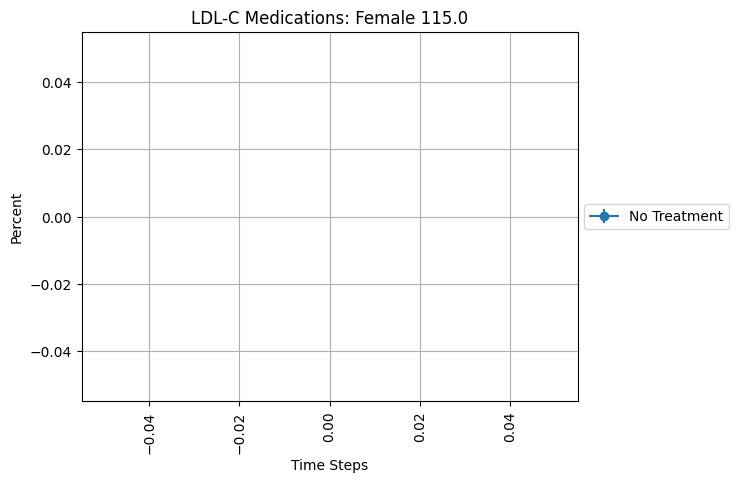

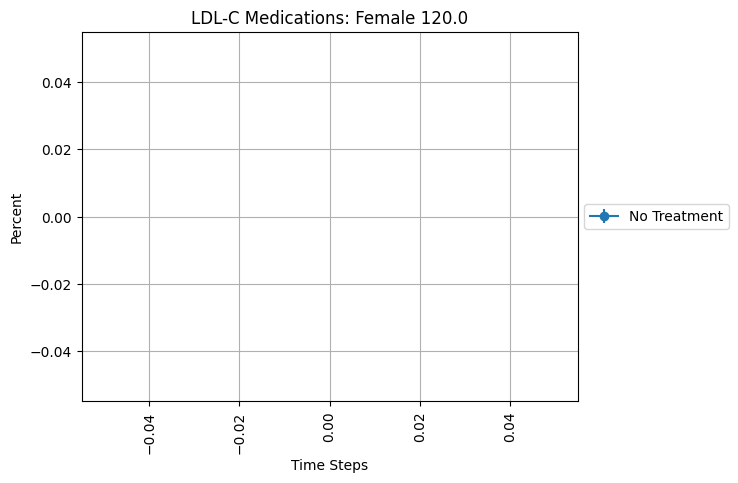

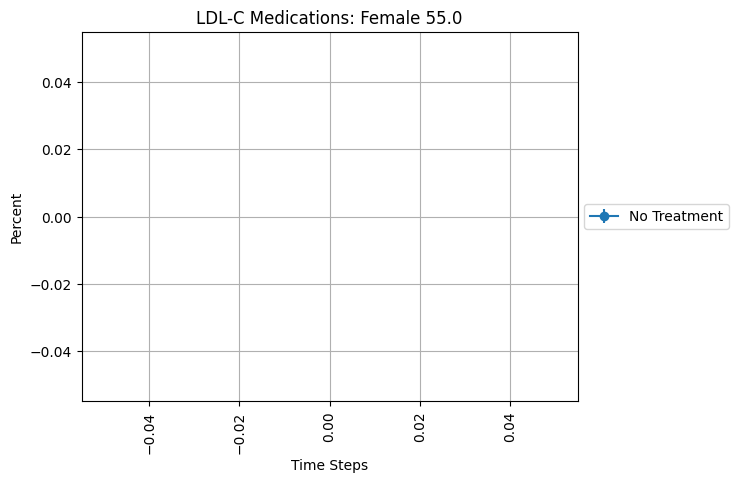

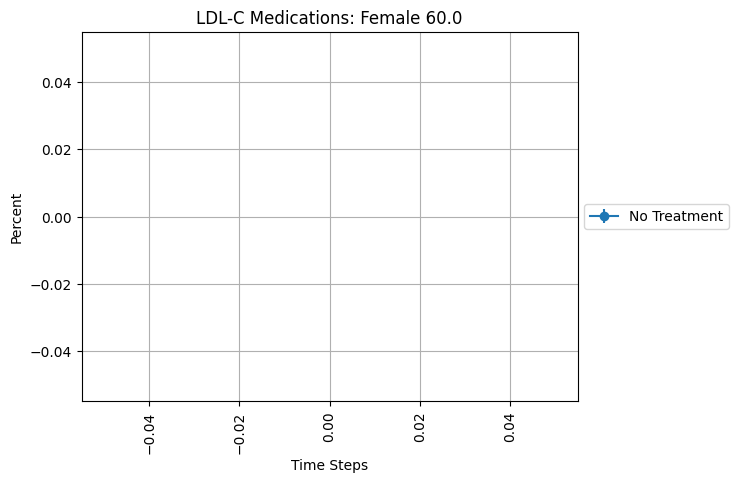

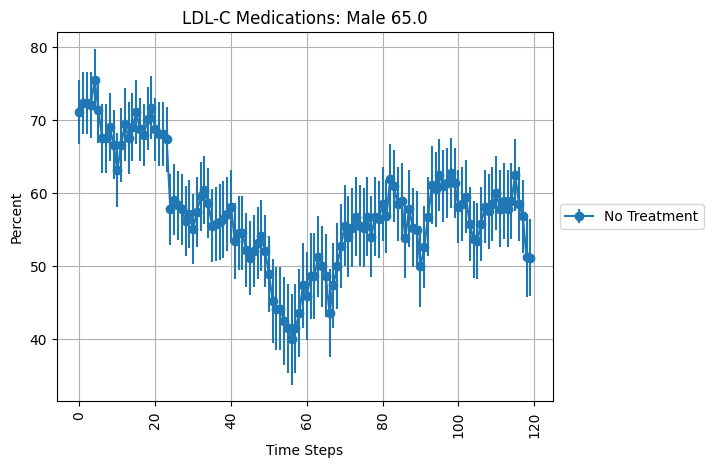

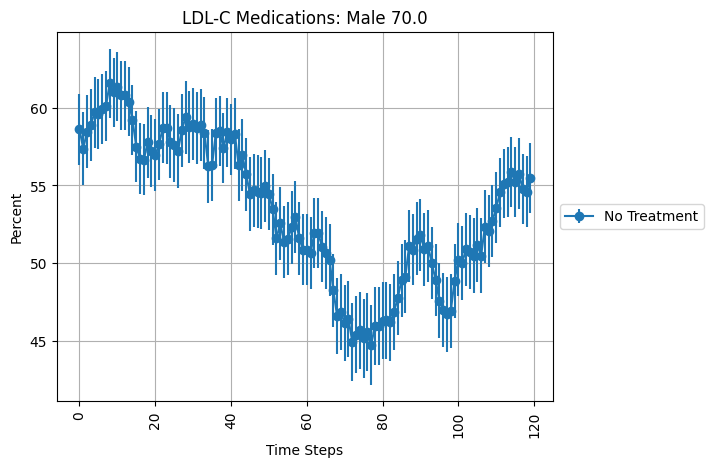

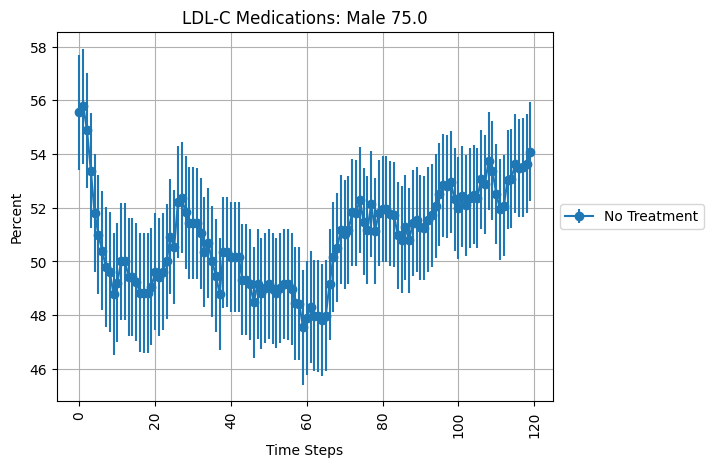

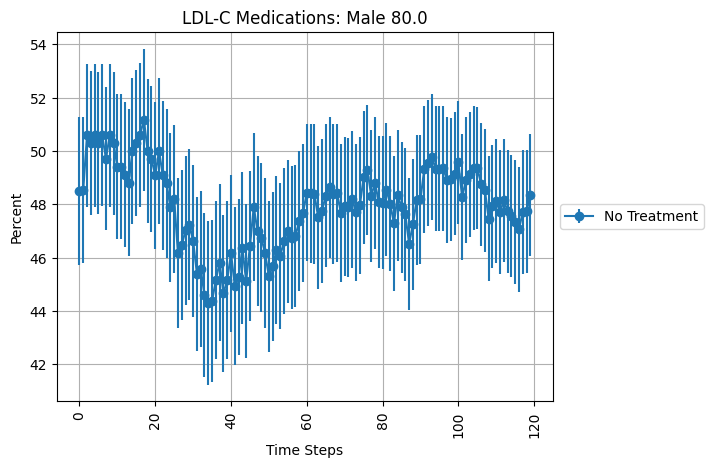

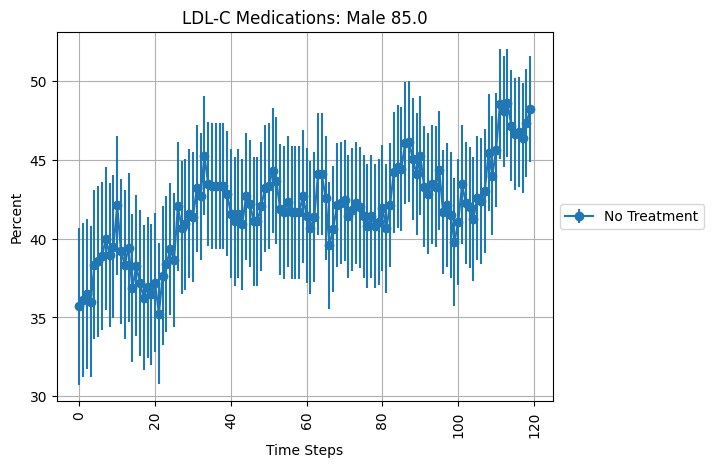

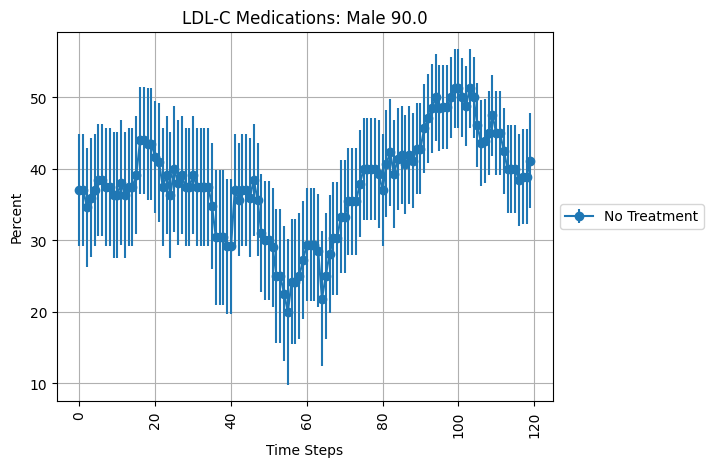

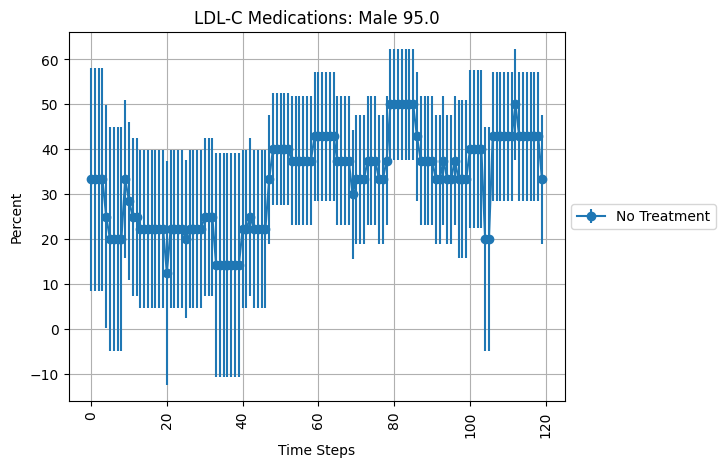

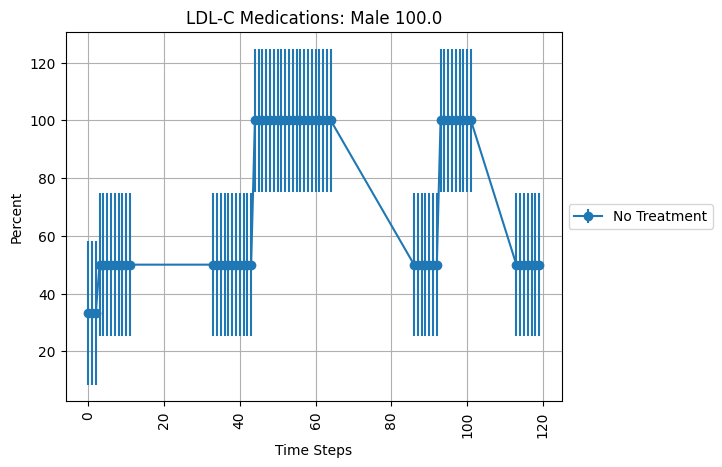

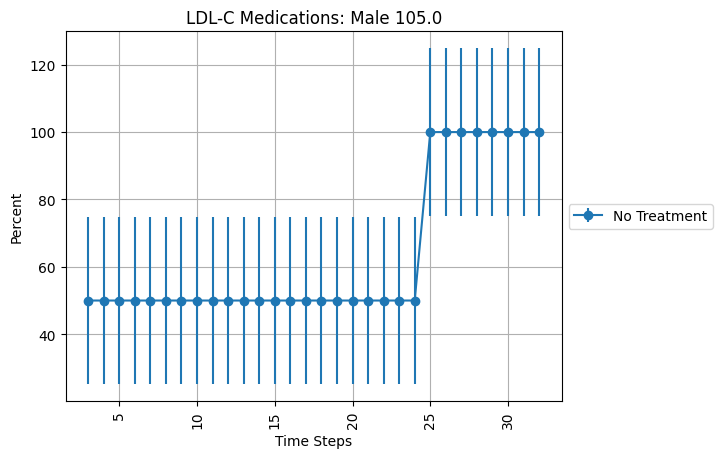

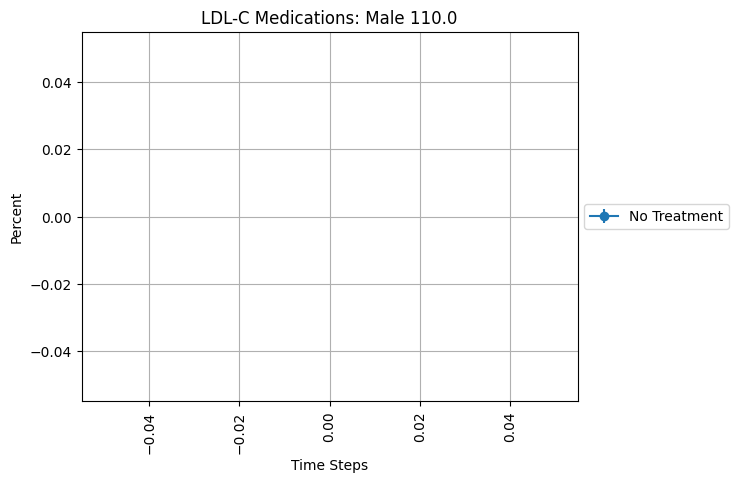

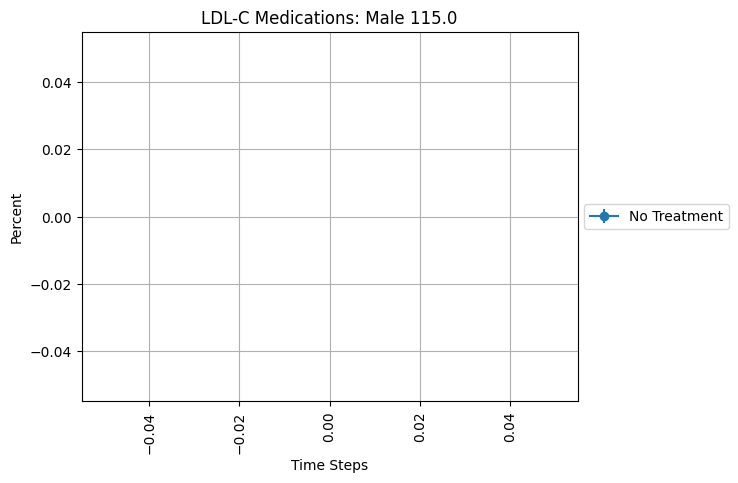

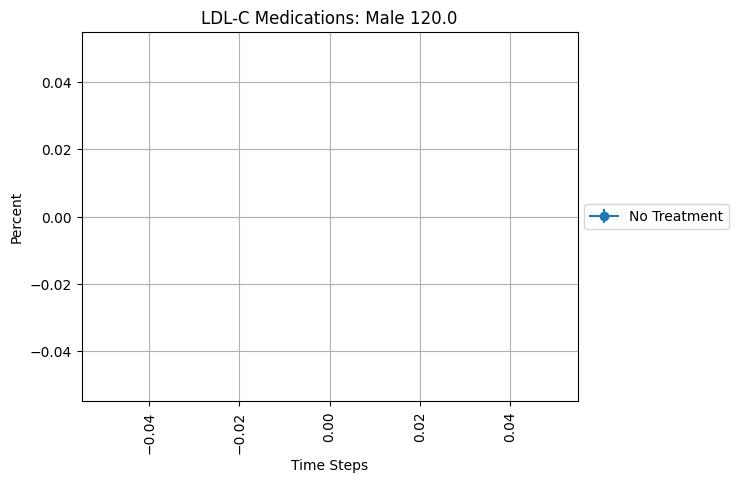

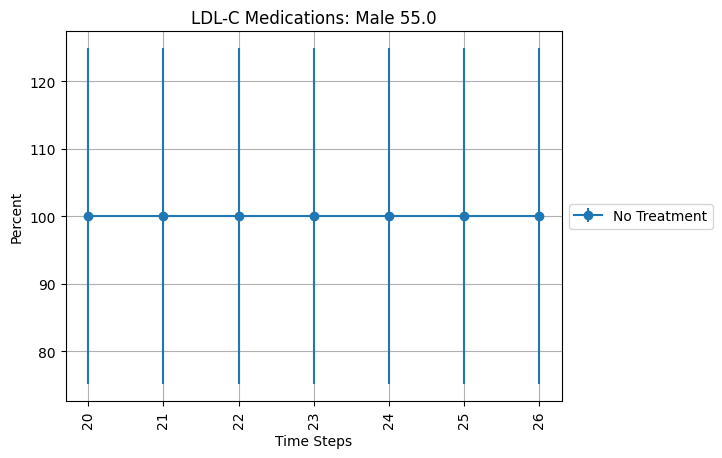

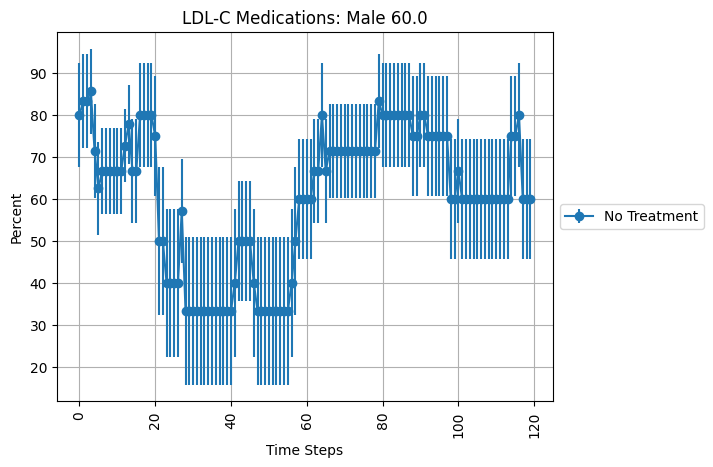

In [10]:
percentages = percentages_ldl
for sex in percentages.sex.unique():
    for age in percentages.age_start.unique(): 
        plt.figure() 
        no_trt = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.ldlc_medication=='no_treatment')]
        plt.errorbar(no_trt['step'], no_trt[0], yerr=no_trt['final_error'], marker='o')
        #one_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_half_dose_efficacy')]
        #plt.plot(one_half['step'], one_half[0], marker='o')
        #one_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_std_dose_efficacy')]
        #plt.plot(one_std['step'], one_std[0], marker='o')
        #two_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_half_dose_efficacy')]
        #plt.plot(two_half['step'], two_half[0], marker='o')
        #two_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_std_dose_efficacy')]
        #plt.plot(two_std['step'], two_std[0], marker='o')
        #three_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_half_dose_efficacy')]
        #plt.plot(three_half['step'], three_half[0], marker='o')
        #three_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_std_dose_efficacy')]
        #plt.plot(three_std['step'], three_std[0], marker='o')
        plt.title(f'LDL-C Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.ylabel('Percent')
        plt.xlabel('Time Steps')
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()

/tmp/ipykernel_4078198/3773284282.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


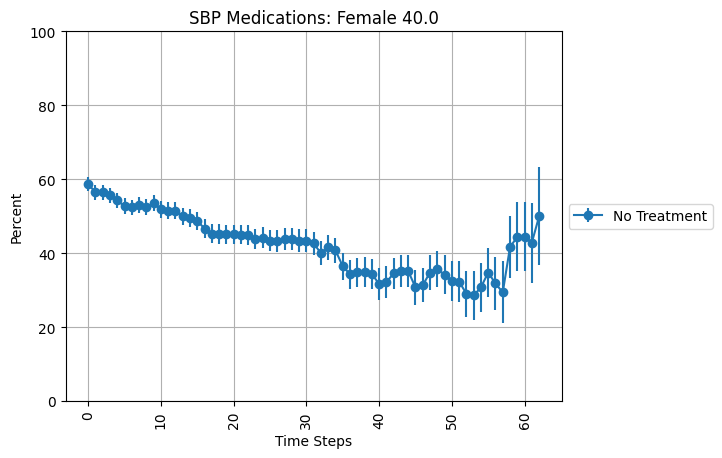

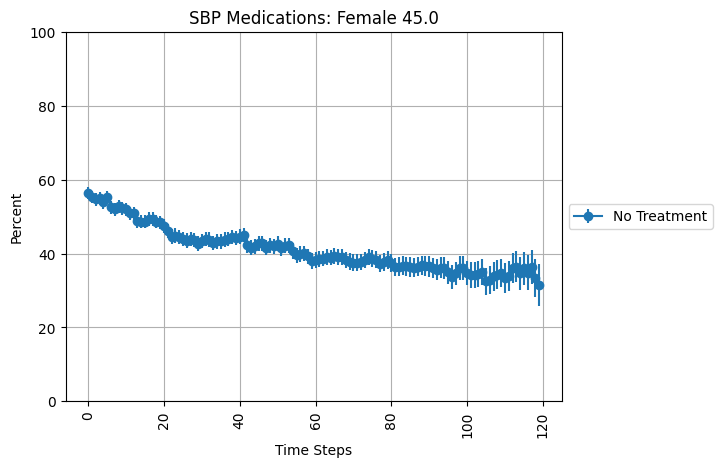

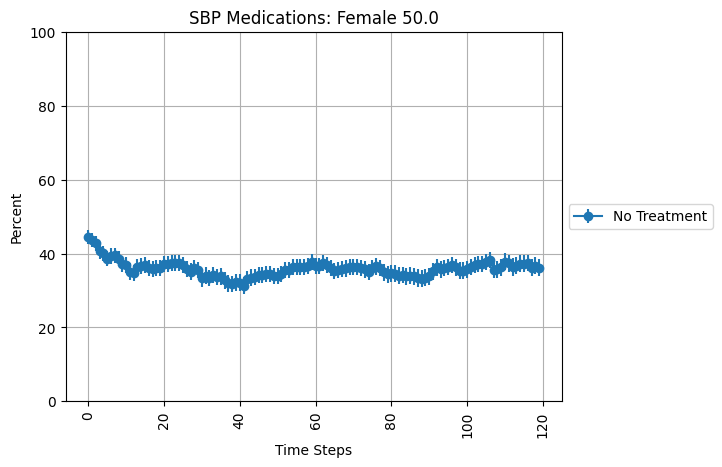

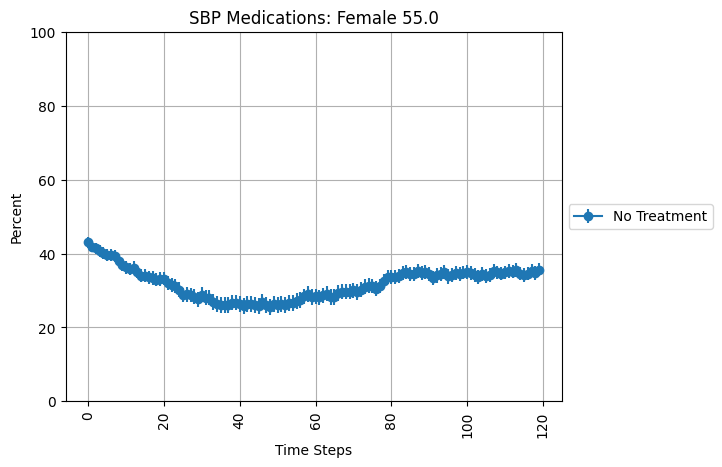

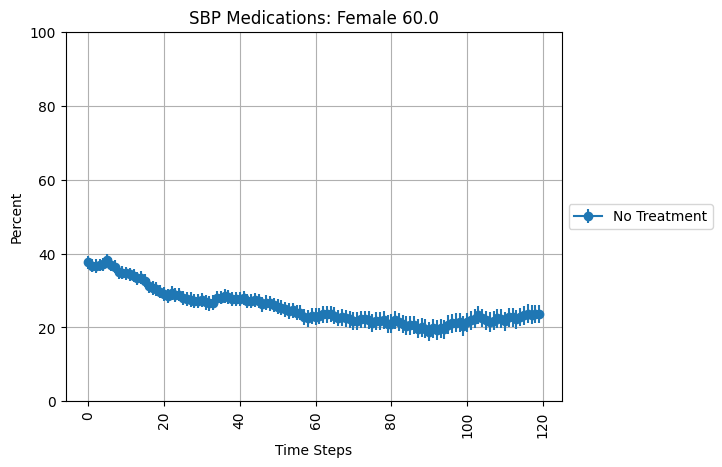

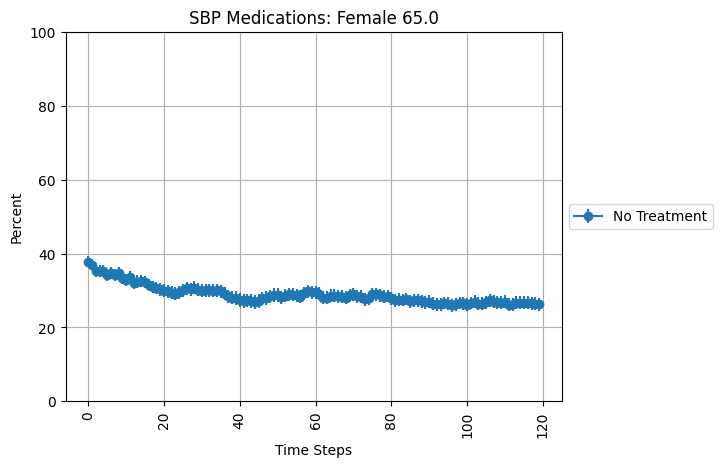

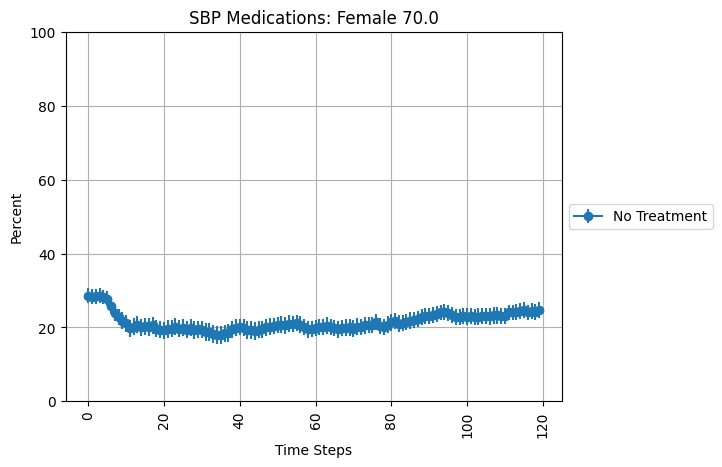

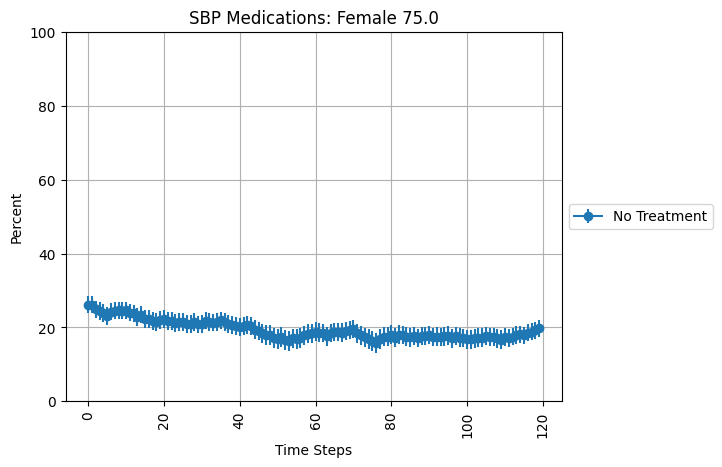

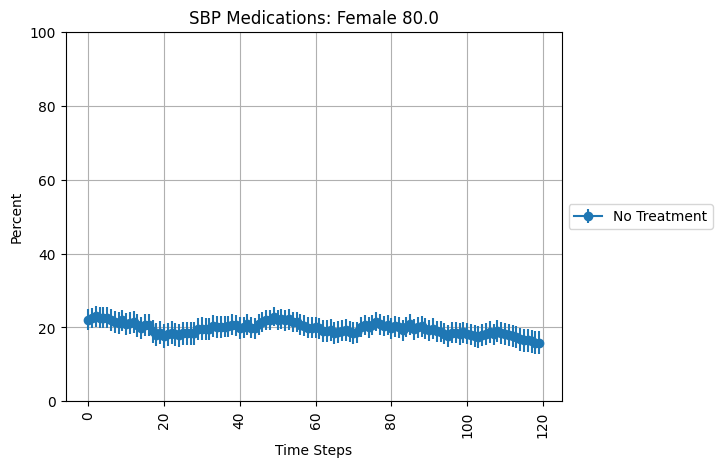

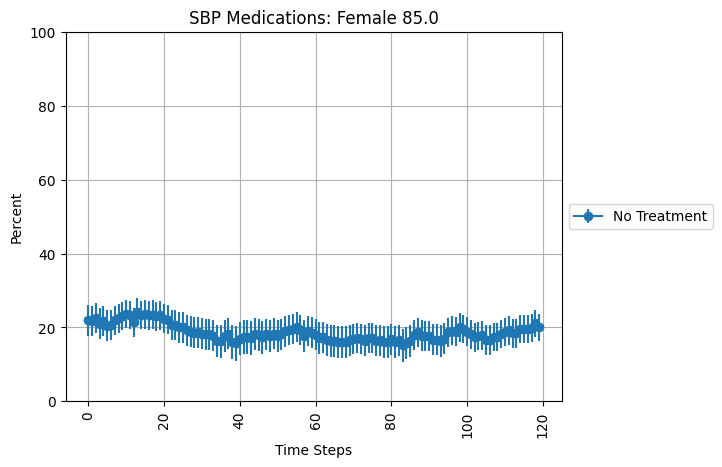

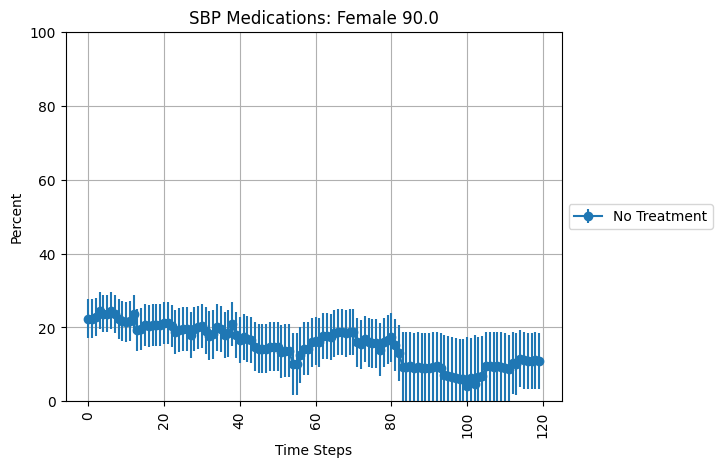

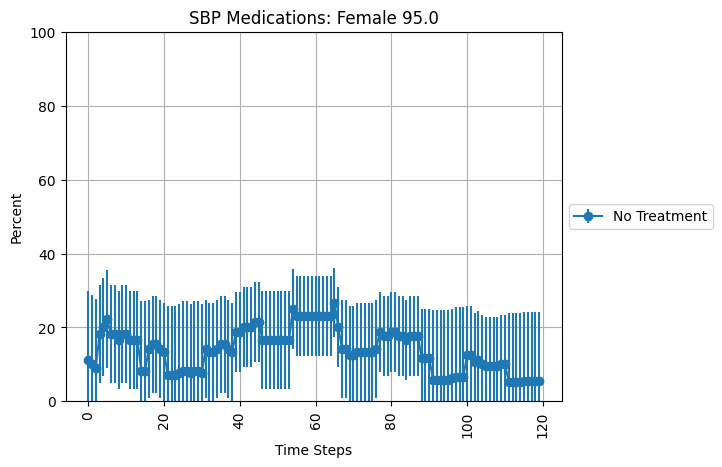

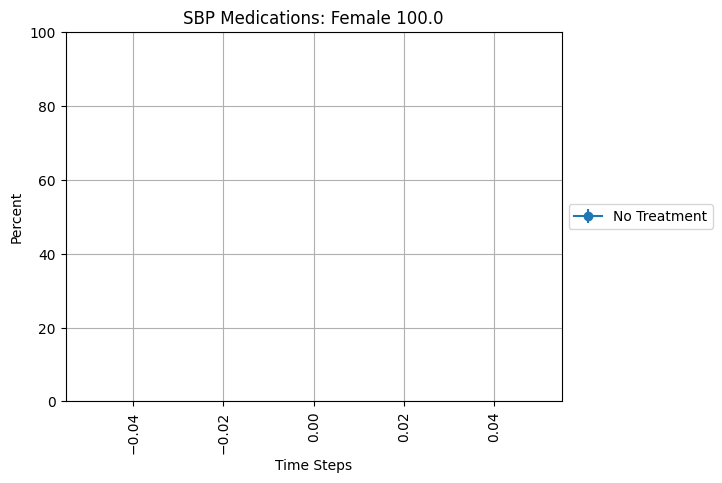

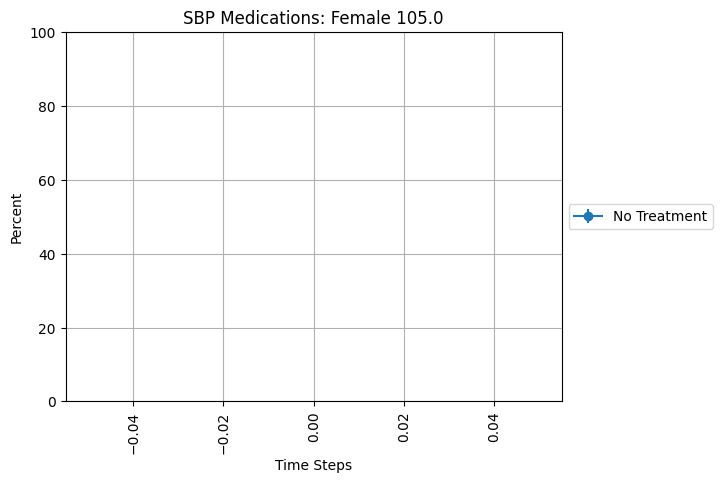

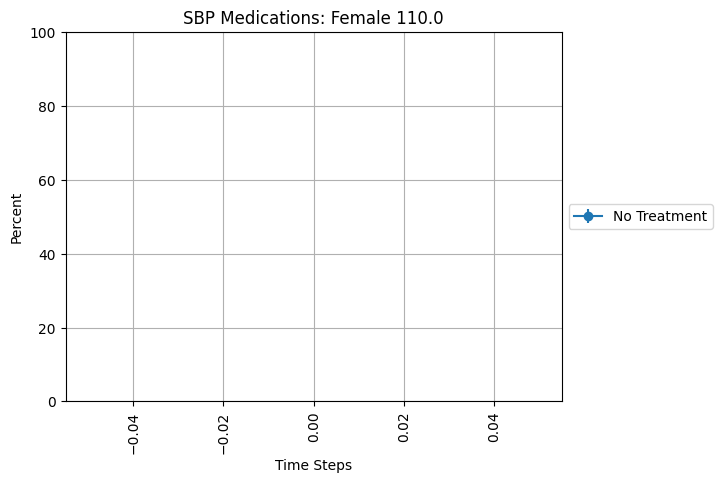

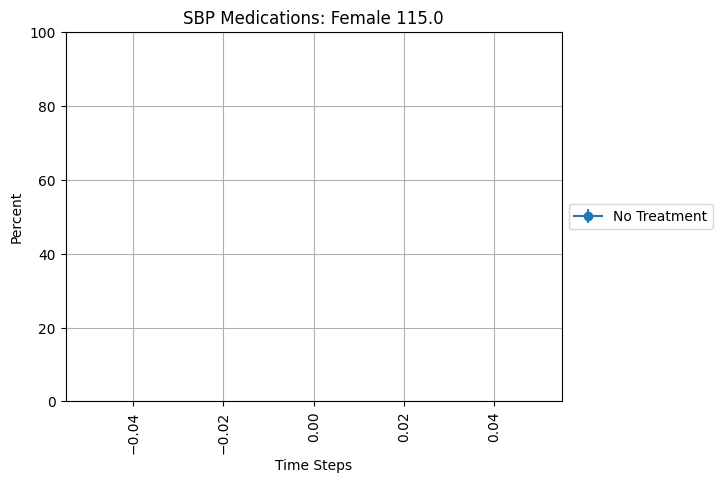

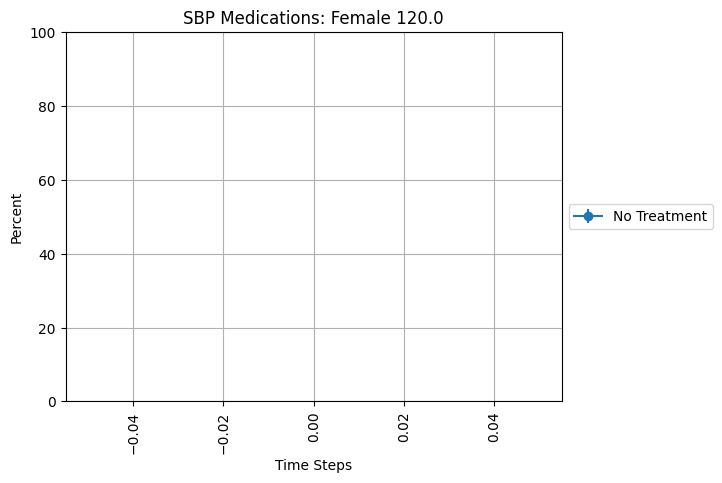

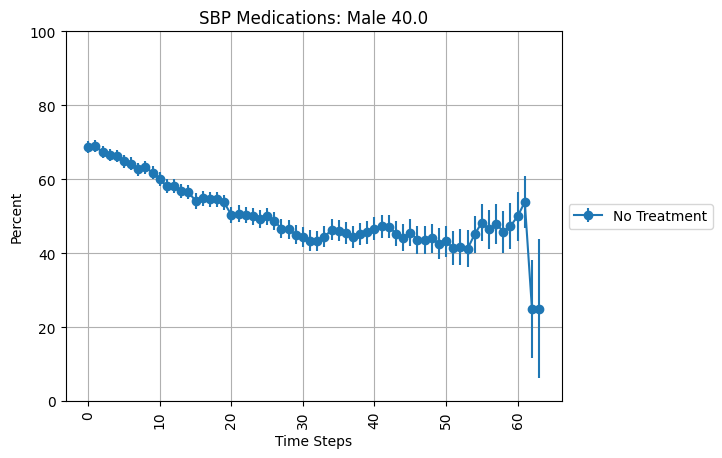

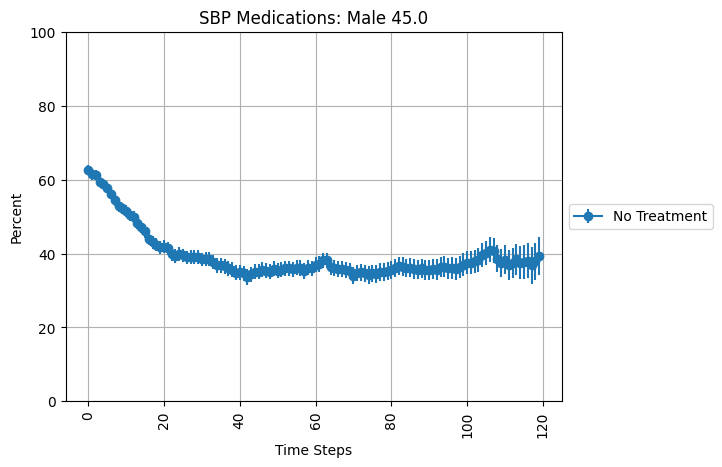

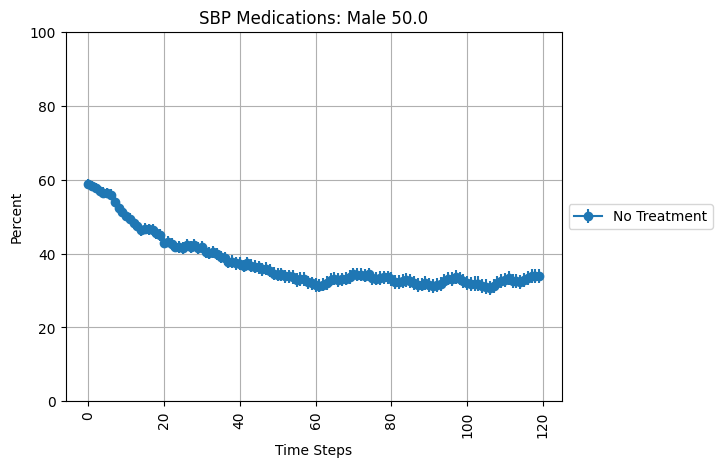

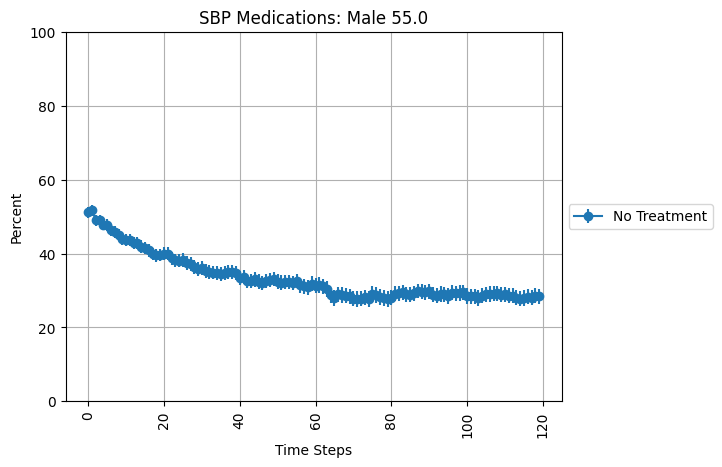

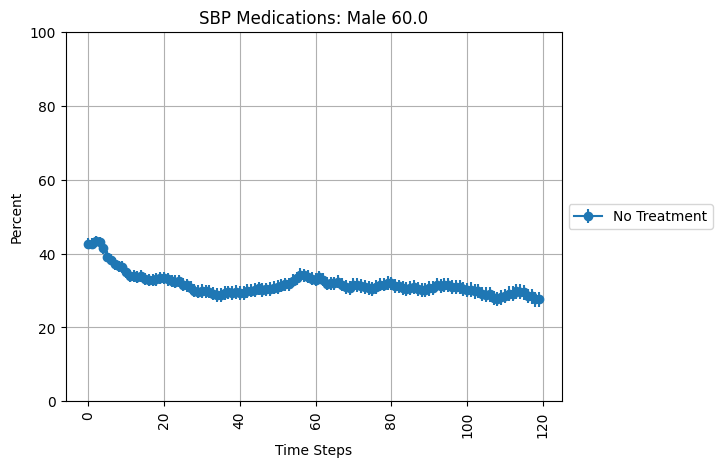

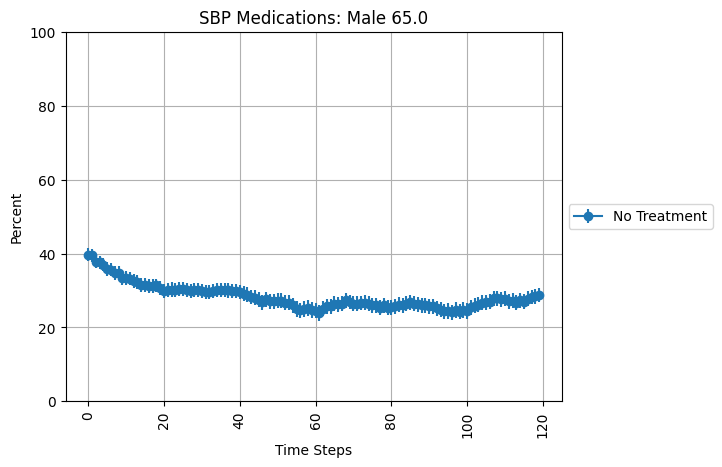

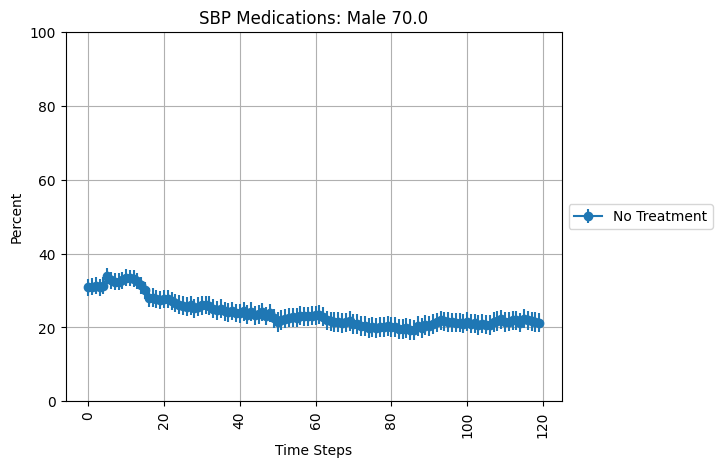

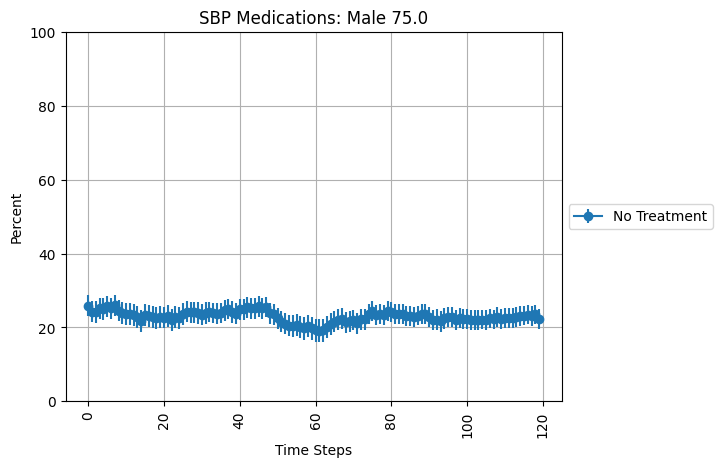

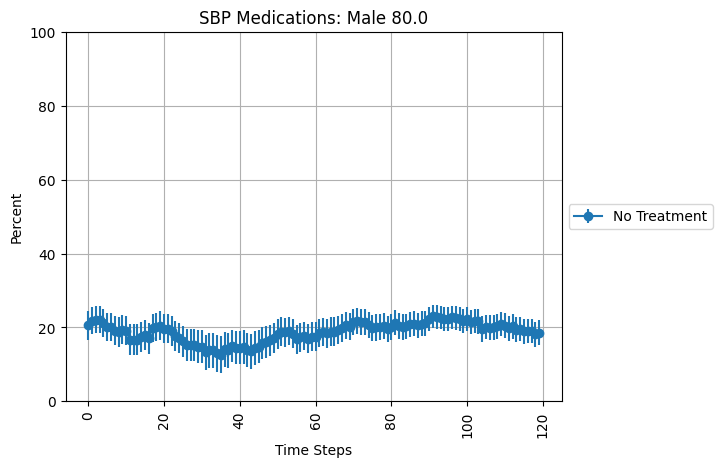

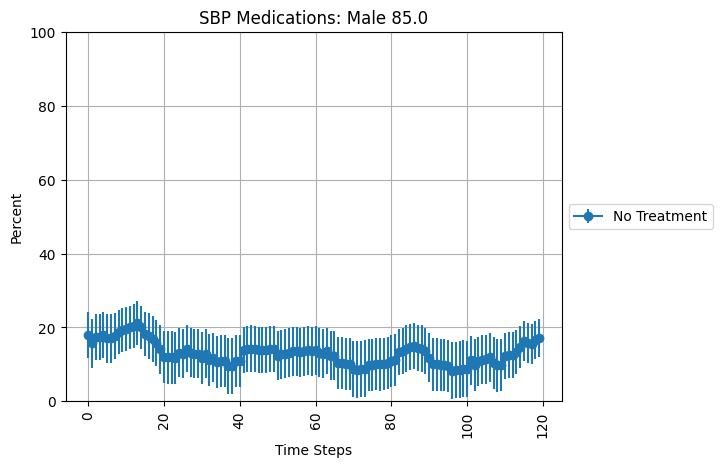

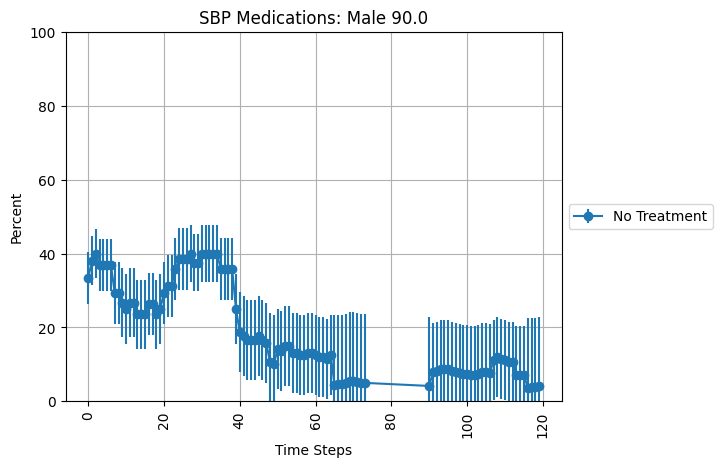

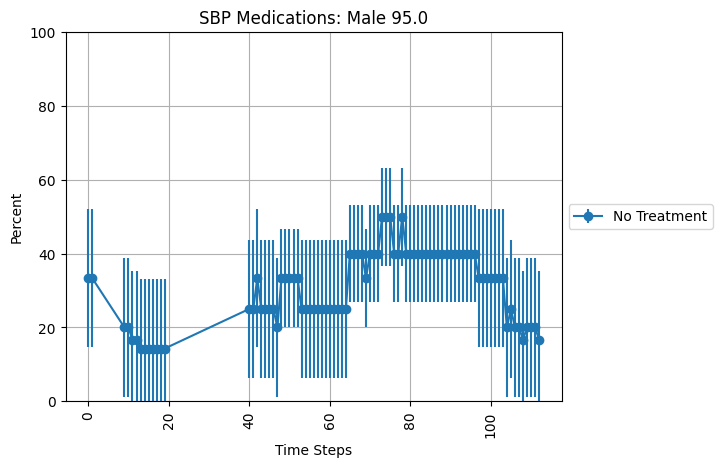

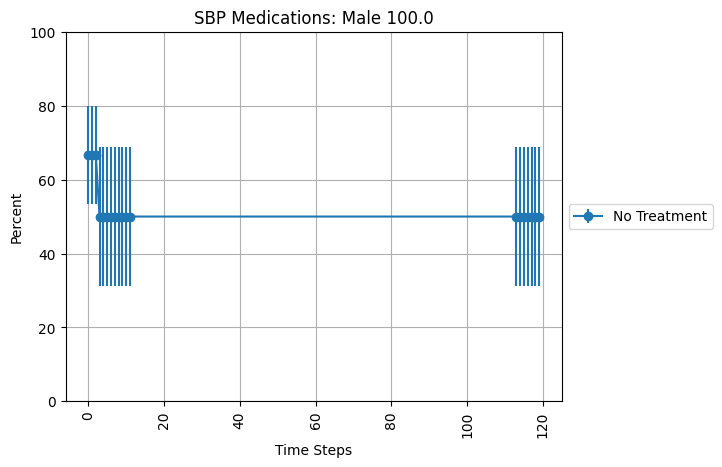

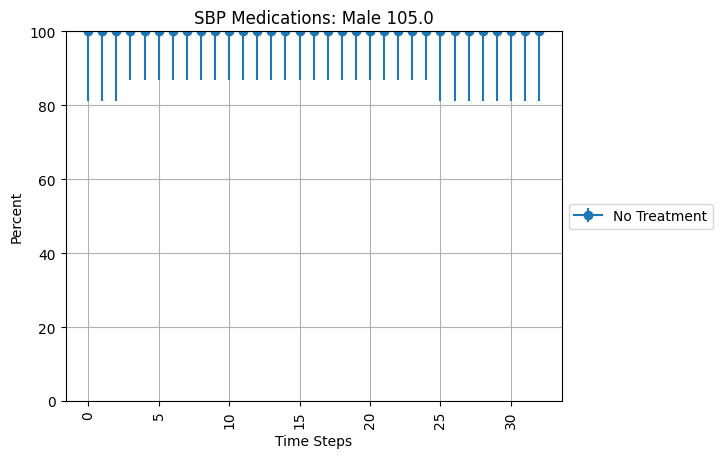

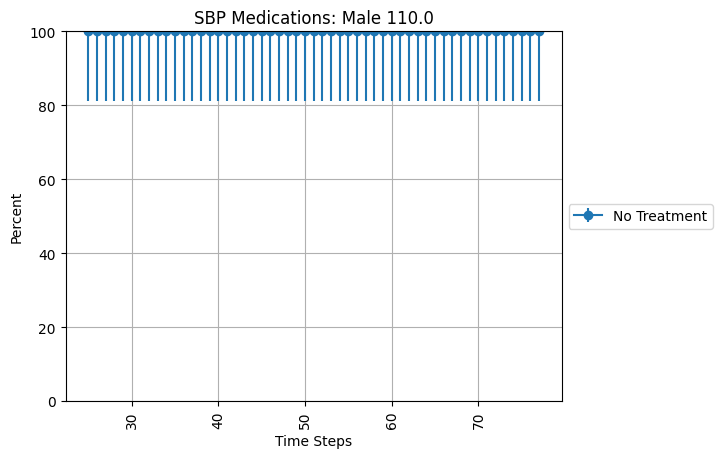

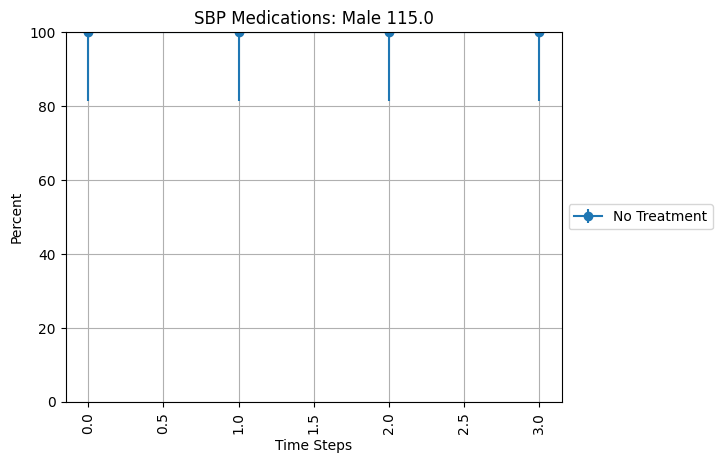

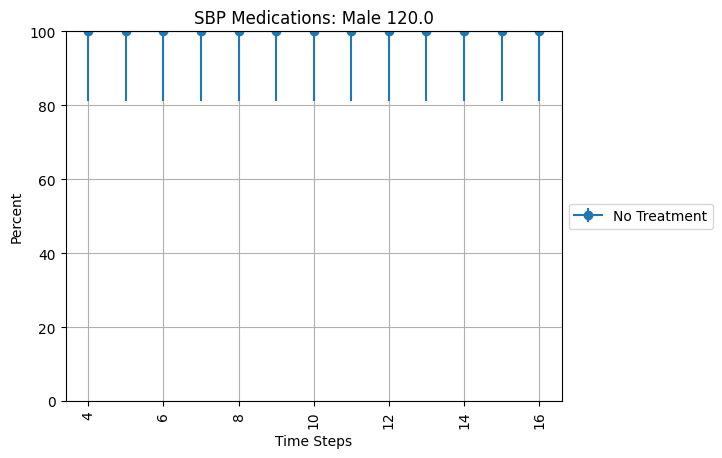

In [12]:
percentages = percentages_sbp
for sex in percentages.sex.unique():
    for age in percentages.age_start.unique(): 
        plt.figure() 
        no_trt = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='no_treatment')]
        plt.errorbar(no_trt['step'], no_trt[0], yerr=no_trt['final_error'], marker='o')
        #one_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_half_dose_efficacy')]
        #plt.plot(one_half['step'], one_half[0], marker='o')
        #one_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='one_drug_std_dose_efficacy')]
        #plt.plot(one_std['step'], one_std[0], marker='o')
        #two_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_half_dose_efficacy')]
        #plt.plot(two_half['step'], two_half[0], marker='o')
        #two_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='two_drug_std_dose_efficacy')]
        #plt.plot(two_std['step'], two_std[0], marker='o')
        #three_half = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_half_dose_efficacy')]
        #plt.plot(three_half['step'], three_half[0], marker='o')
        #three_std = percentages.loc[(percentages.sex==sex) & (percentages.age_start==age) & (percentages.sbp_medication=='three_drug_std_dose_efficacy')]
        #plt.plot(three_std['step'], three_std[0], marker='o')
        plt.title(f'SBP Medications: {sex} {age}') 
        plt.xticks(rotation=90)
        plt.ylabel('Percent')
        plt.xlabel('Time Steps')
        plt.ylim(0,100)
        plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
        plt.grid()